In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
from sklearn.cross_validation import train_test_split

import edward as ed

from edward.models import PointMass,WishartFull, WishartCholesky, MultivariateNormalCholesky, MultivariateNormalFull

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%load_ext autoreload

In [3]:
ed.__version__, tf.__version__, np.__version__

('1.2.1', '1.0.0', '1.11.0')

In [4]:
D = 2
N = 10000
cov = np.array([[1.5, 0.2],[0.2, 0.1]])
X = sps.multivariate_normal.rvs(mean = np.zeros(D), cov = cov, size=N)

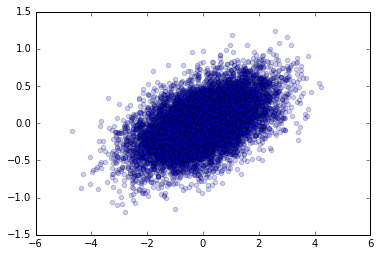

In [5]:
plt.scatter(*X.T,alpha=.2);

## probabilistic model

In [6]:
# priors
v_prior = tf.Variable(3., dtype=tf.float64, trainable=False)
W_prior = tf.Variable(np.array([[1., 0.], [0., 1.]]),
                      dtype=tf.float64, trainable=False)
m_prior = tf.Variable(np.array([0.5, 0.5]), dtype=tf.float64, trainable=False)
k_prior = tf.Variable(0.6, dtype=tf.float64, trainable=False)

In [7]:
#x = MultivariateNormalFull(mu=tf.zeros([n, d]), sigma=tf.stack([tf.eye(d)]*n))
sigma = WishartFull(df=v_prior, scale=W_prior)
mu = MultivariateNormalFull(m_prior, k_prior * sigma)
xn = MultivariateNormalCholesky(tf.reshape(tf.tile(mu, [N]), [N, D]),
                            tf.reshape(tf.tile(sigma, [N, 1]), [N, D, D]),name="Alfred")

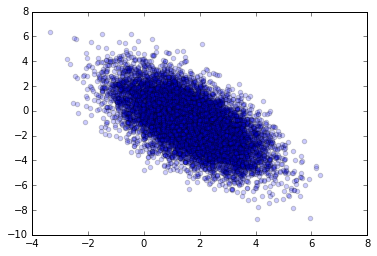

In [8]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    X_sample = xn.sample().eval()
    plt.scatter(*X_sample.T,alpha=.2);

In [9]:
print('***** PROBABILISTIC MODEL *****')
print('mu: {}'.format(mu))
print('sigma: {}'.format(sigma))
print('xn: {}'.format(xn))

***** PROBABILISTIC MODEL *****
mu: <ed.RandomVariable 'MultivariateNormalFull/' shape=(2,) dtype=tf.float64>
sigma: <ed.RandomVariable 'WishartFull/' shape=(2, 2) dtype=tf.float64>
xn: <ed.RandomVariable 'Alfred/' shape=(10000, 2) dtype=tf.float64>


## variational model

qmu = MultivariateNormalCholesky(
    tf.Variable(tf.random_normal([D], dtype=tf.float64), name='v1'),
    tf.nn.softplus(
        tf.Variable(tf.random_normal([D, D], dtype=tf.float64), name='v2')))
qsigma = WishartCholesky(
    tf.nn.softplus(
        tf.Variable(tf.random_normal([], dtype=tf.float64), name='v3')),
    tf.nn.softplus(
        tf.Variable(tf.random_normal([D, D], dtype=tf.float64), name='v4')))

In [10]:
m = tf.Variable(tf.random_normal([D], dtype=tf.float64))
covmat = tf.nn.softplus(
        tf.Variable(tf.random_normal([D, D], dtype=tf.float64)))
qmu = MultivariateNormalCholesky(m,covmat)
L = tf.nn.softplus(
        tf.Variable(tf.random_normal([D, D], dtype=tf.float64)))
LLT = tf.matmul(L,L,transpose_b=True)
qsigma = WishartFull(
    tf.nn.softplus(
        tf.Variable(tf.random_normal([], dtype=tf.float64))),
    LLT
    )

In [11]:
print('***** VARIATIONAL MODEL *****')
print('qmu: {}'.format(qmu))
print('qsigma: {}'.format(qsigma))

***** VARIATIONAL MODEL *****
qmu: <ed.RandomVariable 'MultivariateNormalCholesky/' shape=(2,) dtype=tf.float64>
qsigma: <ed.RandomVariable 'WishartFull_1/' shape=(2, 2) dtype=tf.float64>


In [12]:
#inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={xn: X})
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={xn: X})

In [13]:
%%debug
inference.initialize()

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()

ipdb> q
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/home/folzd/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py in initialize(self, n_samples, *args, **kwargs)
     64     """
     65     self.n_samples = n_samples
---> 66     return super(KLqp, self).initialize(*args, **kwargs)
     67 
     68   def build_loss_and_gradients(self, var_list):

/home/folzd/anaconda3/lib/python3.5/site-packages/edward/inferences/variational_inference.py in initialize(self, optimizer, var_list, use_prettytensor, *args, **kwargs)
     68         var_list = None
     69 
---> 70     self.loss, grads_and_vars = self.build_loss_and_gradients(var_list)
     71 
     72     if optimizer is None:

/home/folzd/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py in build_loss_and_gradients(self, v

In [14]:
inference.initialize()

ValueError: Variable_8/read:0, type=<dtype: 'float32'>, must be of the same type (<dtype: 'float64'>) as inference_139625060831016/0/Alfred/init/mu:0.

In [51]:
[var.name for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]

['Variable:0',
 'Variable_1:0',
 'Variable_2:0',
 'Variable_3:0',
 'Variable_4:0',
 'Variable_5:0',
 'Variable_6:0',
 'Variable_7:0',
 'Variable_9:0',
 'Variable_10:0',
 'Variable_11:0',
 'Variable_12:0',
 'Variable_13:0',
 'Variable_14:0',
 'Variable_15:0',
 'Variable_16:0',
 'Variable_17:0',
 'Variable_18:0',
 'Variable_20:0',
 'Variable_22:0',
 'Variable_24:0',
 'Variable_25:0',
 'Variable_26:0',
 'Variable_27:0',
 'Variable_28:0',
 'Variable_30:0']

In [48]:
tf.get_variable_scope()

In [108]:
Variable_31

NameError: name 'Variable_31' is not defined

In [107]:
sess = ed.get_session()
#init = tf.initialize_all_variables()
init = tf.global_variables_initializer()
init.run()

for t in range(5):
    inference.update()
    inference.print_progress(info_dict)

AttributeError: 'KLqp' object has no attribute 'train'

In [52]:
#inference.run(n_iter=3000, n_samples=10, n_minibatch=8)
inference.run(n_iter=2000, n_samples=20,n_print=100)

RuntimeError: dimension: Conversion function <function _constant_tensor_conversion_function at 0x7f896b001c80> for type <class 'object'> returned incompatible dtype: requested = float64_ref, actual = float64

In [45]:
tmp = qx.sample().eval()

In [46]:
tf.matmul(qsigma_half,qsigma_half,transpose_b=True).eval()

array([[ 2266.78149414,  -735.15661621],
       [ -735.15661621,  2742.12915039]], dtype=float32)

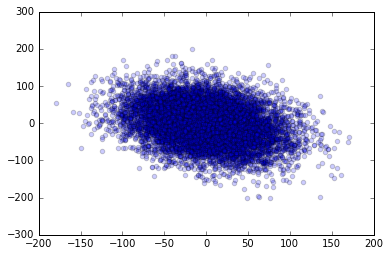

In [47]:
plt.scatter(*tmp.T,alpha=.2);

http://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/#Covariance_matrix_as_a_linear_transformation
https://github.com/blei-lab/edward/issues/471
https://discourse.edwardlib.org